In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import regularizers
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-04-08 15:40:25.080544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_csv('/Users/inigoparra/Desktop/GitHub Repositories/Eu2Vec-Models/augmented-master.csv')
print(len(data))

import pandas as pd
import numpy as np
from collections import Counter

def count_unique_tokens(data, columns=None):

    if columns is None:
        columns = data.columns

    text_data = data[columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tokens = text_data.str.split().explode()
    unique_tokens = len(np.unique(tokens))

    return unique_tokens


unique_tokens_count = count_unique_tokens(data)
print(f'The number of unique tokens in the DataFrame is: {unique_tokens_count}')


26046
The number of unique tokens in the DataFrame is: 28360


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']
X_val = val_data['text']
y_val = val_data['label']


In [5]:
with open('/Users/inigoparra/Desktop/GitHub Repositories/WiBaSets/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [6]:
import re
import nltk

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'[0-9]', '', text) 
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.split() 
    text = ' '.join(text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_val = X_val.apply(clean_text)

print(X_train[2])

gogo aldaketarako itxaropena tilosetan


In [7]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))

Unique labels in y_train: [0 1 2]
Unique labels in y_val: [0 1 2]


In [10]:
max_features = 28370
max_len = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')


In [19]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(16, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.05),
               recurrent_regularizer=regularizers.l2(0.05))))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(8)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:
batch_size = 16
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
1172/1172 [==============================] - 36s 28ms/step - loss: 1.3996 - accuracy: 0.4436 - val_loss: 0.8668 - val_accuracy: 0.5626
Epoch 2/100
1172/1172 [==============================] - 31s 27ms/step - loss: 0.7300 - accuracy: 0.6700 - val_loss: 0.6787 - val_accuracy: 0.7415
Epoch 3/100
1172/1172 [==============================] - 32s 27ms/step - loss: 0.4787 - accuracy: 0.8290 - val_loss: 0.6016 - val_accuracy: 0.7833
Epoch 4/100
1172/1172 [==============================] - 32s 27ms/step - loss: 0.3314 - accuracy: 0.8929 - val_loss: 0.6398 - val_accuracy: 0.7929
Epoch 5/100
1172/1172 [==============================] - 33s 28ms/step - loss: 0.2575 - accuracy: 0.9190 - val_loss: 0.6966 - val_accuracy: 0.7936
Epoch 6/100
1172/1172 [==============================] - 32s 27ms/step - loss: 0.2213 - accuracy: 0.9304 - val_loss: 0.7547 - val_accuracy: 0.7997


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Generate predictions
y_pred_probs = model.predict(X_val_pad)
y_pred = np.argmax(y_pred_probs, axis=-1)

# Calculate precision, recall, and F1 scores
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

147/147 [==============================] - 2s 7ms/step
Precision: 0.7852610660060402
Recall: 0.7833226700789081
F1 score: 0.7830643771581447


In [22]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

82/82 [==============================] - 1s 7ms/step - loss: 0.6578 - accuracy: 0.7585
Test loss: 0.6578224897384644, Test accuracy: 0.7585412859916687


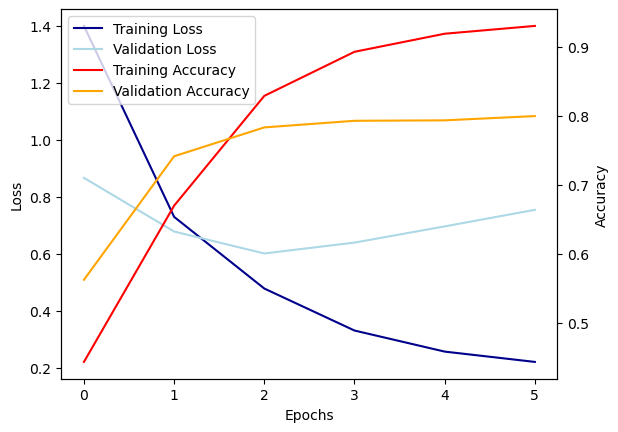

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.twinx()  # Create a second y-axis that shares the same x-axis
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylabel('Accuracy')

handles, labels = [], []
for ax in plt.gcf().axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels)

plt.show()

147/147 [==============================] - 1s 7ms/step


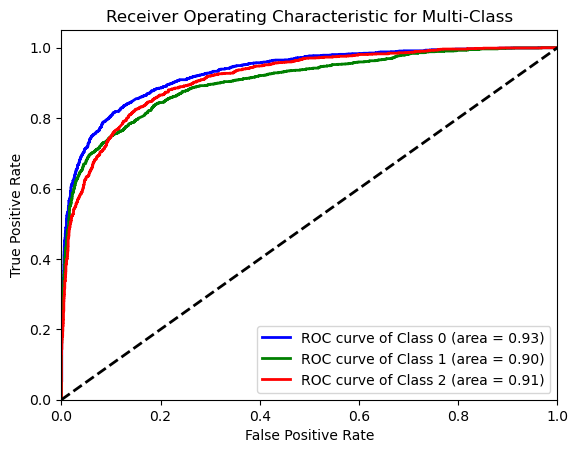

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_onehot = label_binarize(y_train, classes=[0, 1, 2])
y_val_onehot = label_binarize(y_val, classes=[0, 1, 2])
y_pred_proba = model.predict(X_val_pad)
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'green', 'red']
class_labels = ['Class 0', 'Class 1', 'Class 2']
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()



In [62]:
# Assume that X_test is a list of input phrases to predict
X_test = ['Oso ondo joan zen partida, egun guztia zoriontzen egon ginen']

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

predictions = model.predict(X_test_pad)

predicted_classes = predictions.argmax(axis=1)

print('Predicted classes:', predicted_classes)


1/1 [==============================] - 0s 23ms/step
Predicted classes: [2]


In [63]:
# Get the embedding layer weights
# Create a dictionary of word embeddings with labels
# Get the word index from the tokenizer

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

word_index = tokenizer.word_index

embeddings_index = {}
for word, i in word_index.items():
    embeddings_index[word] = weights[i]

with open('embeddings.txt', 'w') as f:
    for word, emb in embeddings_index.items():
        f.write(word + ' ')
        f.write(' '.join(str(x) for x in emb))
        f.write('\n')